In [2]:
import os
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from pathlib import Path
from wordcloud import WordCloud
import matplotlib.pyplot as plt

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [26]:
# Load your data
df = pd.read_csv("JEOPARDY_CSV_cleaned.csv")
print(df.shape)
df = df.sample(n=10000, random_state=42) # Samples random rows
documents = df['Question'].tolist()

(216930, 8)


In [14]:
# Setting up the vectorizer with BM25 weighting if required, stopwords, and n-gram range
vectorizer_model = CountVectorizer(ngram_range=(1, 3), stop_words='english', min_df=5)

# UMAP
umap_model = UMAP(n_neighbors=20, n_components=5, metric='cosine')

# HDBSCAN
hdbscan_model = HDBSCAN(min_cluster_size=15, min_samples=2, metric='euclidean', prediction_data=True)

In [15]:
rep_model = KeyBERTInspired()  

# Initialize BERTopic
topic_model = BERTopic(embedding_model="all-mpnet-base-v2", # Using `mpnet` 
                       umap_model= umap_model, 
                       hdbscan_model= hdbscan_model,  
                       vectorizer_model=vectorizer_model,
                       calculate_probabilities=True,  # For viewing topic probabilities
                       seed_topic_list=None,  # Can be specified if you have seed topics
                       representation_model = rep_model,
                       verbose=True)

# Fit the model
topics, probs = topic_model.fit_transform(documents)

2025-10-30 10:41:38,731 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|███████████████████████████████████████████████████████| 313/313 [00:15<00:00, 19.64it/s]
2025-10-30 10:41:56,077 - BERTopic - Embedding - Completed ✓
2025-10-30 10:41:56,077 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2025-10-30 10:42:04,616 - BERTopic - Dimensionality - Completed ✓
2025-10-30 10:42:04,617 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-10-30 10:42:06,721 - BERTopic - Cluster - Completed ✓
2025-10-30 10:42:06,724 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-10-30 10:42:08,046 - BERTopic - Representation - Completed ✓


In [16]:
# Define where you want to save
save_dir = "./results"

# Create the directory if it doesn’t exist
os.makedirs(save_dir, exist_ok=True)

# Save the model
topic_model.save(os.path.join(save_dir, "topic_model_python"))

2025-10-30 10:42:08,178 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [17]:
# Path to the saved model
model_path = "./results/topic_model_python"

# Load the model
topic_model = BERTopic.load(model_path)

In [18]:
# Viewing topics
for topic_num in range(len(topic_model.get_topic_info()) - 1):  # -1 to exclude the -1 (outlier) topic
    print(f"Topic {topic_num}: {topic_model.get_topic(topic_num)}")
    
# Initialize an empty list to collect topic data
topics_data = []

# Get the number of topics minus the outlier topic
num_topics = len(topic_model.get_topic_info()) - 1

# Iterate over each topic
for topic_num in range(num_topics):
    # Get the topic based on topic number
    topic = topic_model.get_topic(topic_num)
    
    # Each topic is a list of (word, weight) tuples
    for word, weight in topic:
        # Append the topic number, word, and weight as a tuple to the topics_data list
        topics_data.append((topic_num, word, weight))

# Convert the list of tuples into a DataFrame
topics_df = pd.DataFrame(topics_data, columns=['Topic', 'Word', 'Weight'])

# Display the DataFrame
print(topics_df)

topics_df.to_csv('topic_keywords_2.csv', index=False)

Topic 0: [('garden', np.float32(0.1911146)), ('look', np.float32(0.17372414)), ('red', np.float32(0.16772723)), ('bird', np.float32(0.16752173)), ('fly', np.float32(0.1632674)), ('bear', np.float32(0.14905456)), ('fish', np.float32(0.1435324)), ('food', np.float32(0.13273728)), ('known', np.float32(0.13258196)), ('blue', np.float32(0.12890337))]
Topic 1: [('fans', np.float32(0.2637348)), ('plane', np.float32(0.24639663)), ('hotel', np.float32(0.23444359)), ('flying', np.float32(0.21578273)), ('women', np.float32(0.21369138)), ('heart', np.float32(0.20404048)), ('love', np.float32(0.20038459)), ('butler', np.float32(0.18477248)), ('life', np.float32(0.183926)), ('lives', np.float32(0.17727411))]
Topic 2: [('students', np.float32(0.13121642)), ('nuclear', np.float32(0.11643286)), ('1985', np.float32(0.08642314)), ('1988', np.float32(0.07825554)), ('falls', np.float32(0.075929806)), ('1981', np.float32(0.070981085)), ('1984', np.float32(0.07033484)), ('1986', np.float32(0.068691924)), ('1

In [19]:
# If you want to visualize hierarchical clustering of topics
topic_model.visualize_hierarchy()

100%|████████████████████████████████████████████████████████████████| 109/109 [00:13<00:00,  8.26it/s]


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


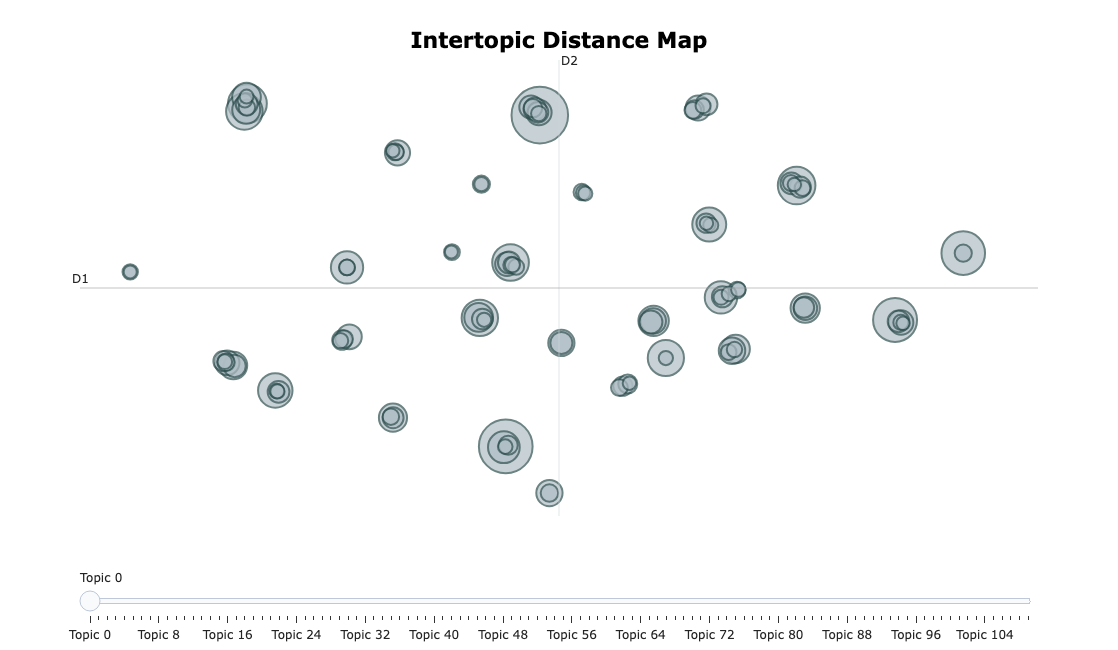

In [20]:
hierarchical_topics = topic_model.hierarchical_topics(documents)
topic_model.visualize_topics()

In [23]:
tree = topic_model.get_topic_tree(hierarchical_topics)
print(tree)

.
├─bird_species_birds_air_animal
│    ├─letter word_means_meaning_term_word
│    │    ├─species_fish_bird_birds_food
│    │    │    ├─letter word_letter term_letters_word term_words
│    │    │    │    ├─letter word_letter term_letters_word term_words
│    │    │    │    │    ├─■──person_dan_affairs_letter_sign ── Topic: 79
│    │    │    │    │    └─■──hold_kids_moment_immediately_question ── Topic: 5
│    │    │    │    └─blood_medical_red_color_legs
│    │    │    │         ├─computer_machine_device_letter term_letter word
│    │    │    │         │    ├─■──place_letter word_alliterative_word term_describes ── Topic: 50
│    │    │    │         │    └─sword_steel_metal_iron_hammer
│    │    │    │         │         ├─■──roll_line_sugar_light_soft ── Topic: 38
│    │    │    │         │         └─■──maker_reports_machine_hands_materials ── Topic: 81
│    │    │    │         └─blood_medical_skin_clothing_red
│    │    │    │              ├─blood_skin_clothing_medical_red
│    │    │ 

In [13]:
# to merge topics which seem highly similar you can:
# note, these are old and not relevant to the current dataset. This is just an example
topics_to_merge = [[2, 35],
                   [17, 24],
                   [23,27,32,34],
                   [26,5],
                   [6,37],
                   [14,30],
                   [13,20,38,11],
                   [3,21,28],
                  [4,29,10]]
                   
topic_model.merge_topics(documents, topics_to_merge)

topic_model.save("./results/topic_model_python_reduced")

2024-05-29 20:38:14,259 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [16]:
# often this is an iterative process, merge, look again, maybe merge again
topics_to_merge = [[3,5],
                   [20,22],
                   [10,7]]
                   
topic_model.merge_topics(documents, topics_to_merge)

#topic_model.save("./results/topic_model_python_reduced")

2024-05-29 21:04:29,982 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [2]:
# Path to the saved model
model_path = "./results/topic_model_python_reduced"

# Load the model
topic_model = BERTopic.load(model_path)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


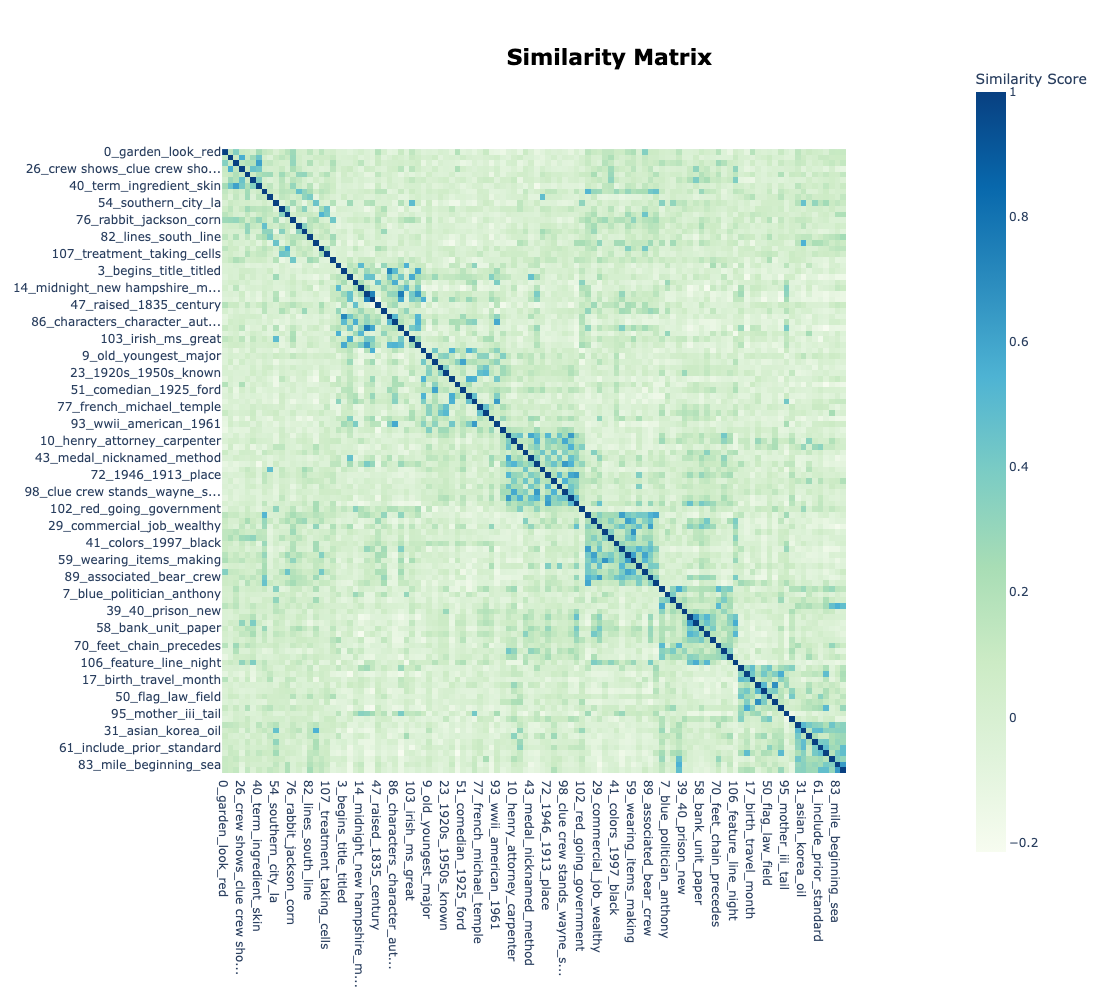

In [21]:
#!pip install -U kaleido

# Visualize the heatmap using BERTopic's function
fig = topic_model.visualize_heatmap(n_clusters=8,width=1000,height=1000)

# Save the Plotly figure to a file (PDF, PNG, etc.)
fig.write_html("topic_similarity.html")
#fig.write_image("topic_heatmap.pdf")  # For PDF
# or
#fig.write_image("topic_heatmap.png")  # For PNG

# To display the figure in a notebook or interactive environment
fig.show()

In [22]:
topics, probs = topic_model.transform(documents)

print(f"Data type of topics list: {type(topics[0])}")
print(f"Unique topics: {set(topics)}")

Batches: 100%|███████████████████████████████████████████████████████| 313/313 [00:19<00:00, 15.82it/s]
2025-10-30 10:42:49,365 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-10-30 10:42:49,409 - BERTopic - Dimensionality - Completed ✓
2025-10-30 10:42:49,410 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-10-30 10:42:49,566 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-10-30 10:42:51,742 - BERTopic - Probabilities - Completed ✓
2025-10-30 10:42:51,743 - BERTopic - Cluster - Completed ✓


Data type of topics list: <class 'numpy.int64'>
Unique topics: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(54), np.int64(55), np.int64(56), np.int64(57), np.int64(58), np.int64(59), np.int64(60), np.int64(61), np.int64(62), np.int64(63), np.int64(64), np.int64(65), np.int64(66), np.int64

Number of documents: 10000
Number of years: 10000


Batches: 100%|███████████████████████████████████████████████████████| 313/313 [00:15<00:00, 19.62it/s]
2025-10-30 10:51:01,792 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-10-30 10:51:01,835 - BERTopic - Dimensionality - Completed ✓
2025-10-30 10:51:01,835 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-10-30 10:51:01,981 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-10-30 10:51:04,120 - BERTopic - Probabilities - Completed ✓
2025-10-30 10:51:04,121 - BERTopic - Cluster - Completed ✓
29it [00:33,  1.15s/it]


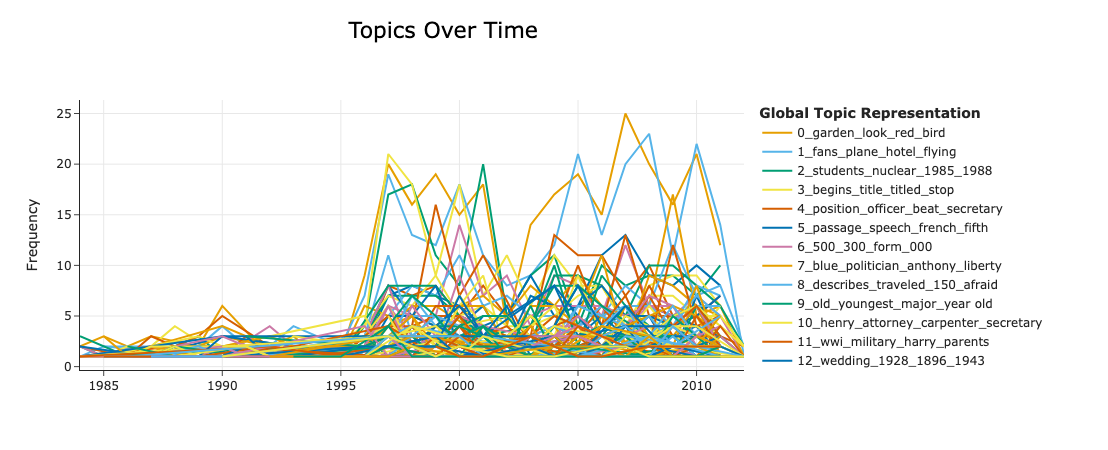

In [32]:
# Convert 'Air Date' to a year and create a simple text column
df["year"] = pd.to_datetime(df["Air Date"], errors="coerce").dt.year
df["notes"] = df["Question"].astype(str).str.strip()  # rename for consistency

# drop rows with missing year (if any) and reset index
df_reduced = df.dropna(subset=["year"]).reset_index(drop=True)

# create your input lists
documents_red = df_reduced["notes"].tolist()
years = df_reduced["year"].astype(int).tolist()

print(f"Number of documents: {len(documents_red)}")
print(f"Number of years: {len(years)}")

# generate topic assignments and topics over time ---
updated_topics, _ = topic_model.transform(documents_red)

topics_over_time = topic_model.topics_over_time(
    documents_red, years, updated_topics
)

# --- visualize ---
topic_model.visualize_topics_over_time(topics_over_time, title="Topics Over Time")

In [23]:
fig = topic_model.visualize_topics_over_time(topics_over_time, title="Topics Over Time")

# Save the Plotly figure to a file (PDF, PNG, etc.)
fig.write_html("topics_over_time.html")

In [33]:
# Pick the column you want to use as your "class"
# (For Jeopardy, this could be 'Round' or 'Category')
class_col = "Round"   # or "Category"

# Make sure it’s string-typed (avoid NaN issues)
classes = df[class_col].astype(str).tolist()

# Make sure your documents come from the same df
documents = df["Question"].astype(str).tolist()

# Calculate topics per class
topics_per_class = topic_model.topics_per_class(documents, classes=classes)

# Inspect results
for c, topic_info in topics_per_class.items():
    print(f"\nClass: {c}")
    for topic_num, topic_details in topic_info.items():
        print(f"  Topic {topic_num}: {topic_details}")

3it [00:05,  1.76s/it]


Class: Topic
  Topic 0: -1
  Topic 1: 1
  Topic 2: 2
  Topic 3: 3
  Topic 4: 4
  Topic 5: 6
  Topic 6: 7
  Topic 7: 8
  Topic 8: 9
  Topic 9: 10
  Topic 10: 13
  Topic 11: 14
  Topic 12: 16
  Topic 13: 18
  Topic 14: 19
  Topic 15: 20
  Topic 16: 21
  Topic 17: 27
  Topic 18: 29
  Topic 19: 30
  Topic 20: 31
  Topic 21: 34
  Topic 22: 43
  Topic 23: 44
  Topic 24: 47
  Topic 25: 48
  Topic 26: 52
  Topic 27: 53
  Topic 28: 56
  Topic 29: 60
  Topic 30: 67
  Topic 31: 68
  Topic 32: 71
  Topic 33: 72
  Topic 34: 79
  Topic 35: 81
  Topic 36: 82
  Topic 37: 88
  Topic 38: 90
  Topic 39: 92
  Topic 40: 93
  Topic 41: 94
  Topic 42: 99
  Topic 43: 100
  Topic 44: 102
  Topic 45: 104
  Topic 46: 106
  Topic 47: -1
  Topic 48: 0
  Topic 49: 1
  Topic 50: 2
  Topic 51: 3
  Topic 52: 4
  Topic 53: 5
  Topic 54: 6
  Topic 55: 7
  Topic 56: 8
  Topic 57: 9
  Topic 58: 10
  Topic 59: 11
  Topic 60: 12
  Topic 61: 13
  Topic 62: 14
  Topic 63: 15
  Topic 64: 16
  Topic 65: 17
  Topic 66: 18
  Top

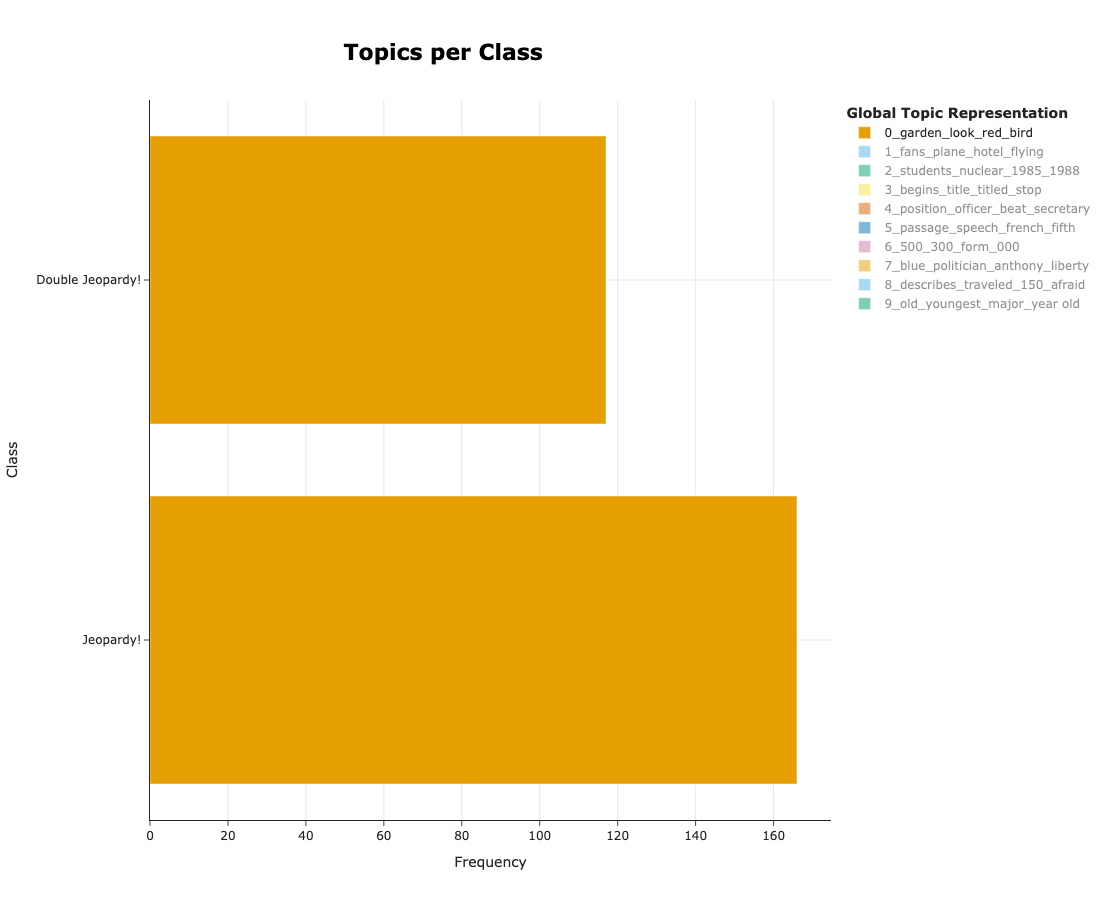

In [34]:
topic_model.visualize_topics_per_class(topics_per_class)

In [26]:
fig = topic_model.visualize_topics_per_class(topics_per_class)

# Save the Plotly figure to a file (PDF, PNG, etc.)
fig.write_html("topics_by_class.html")

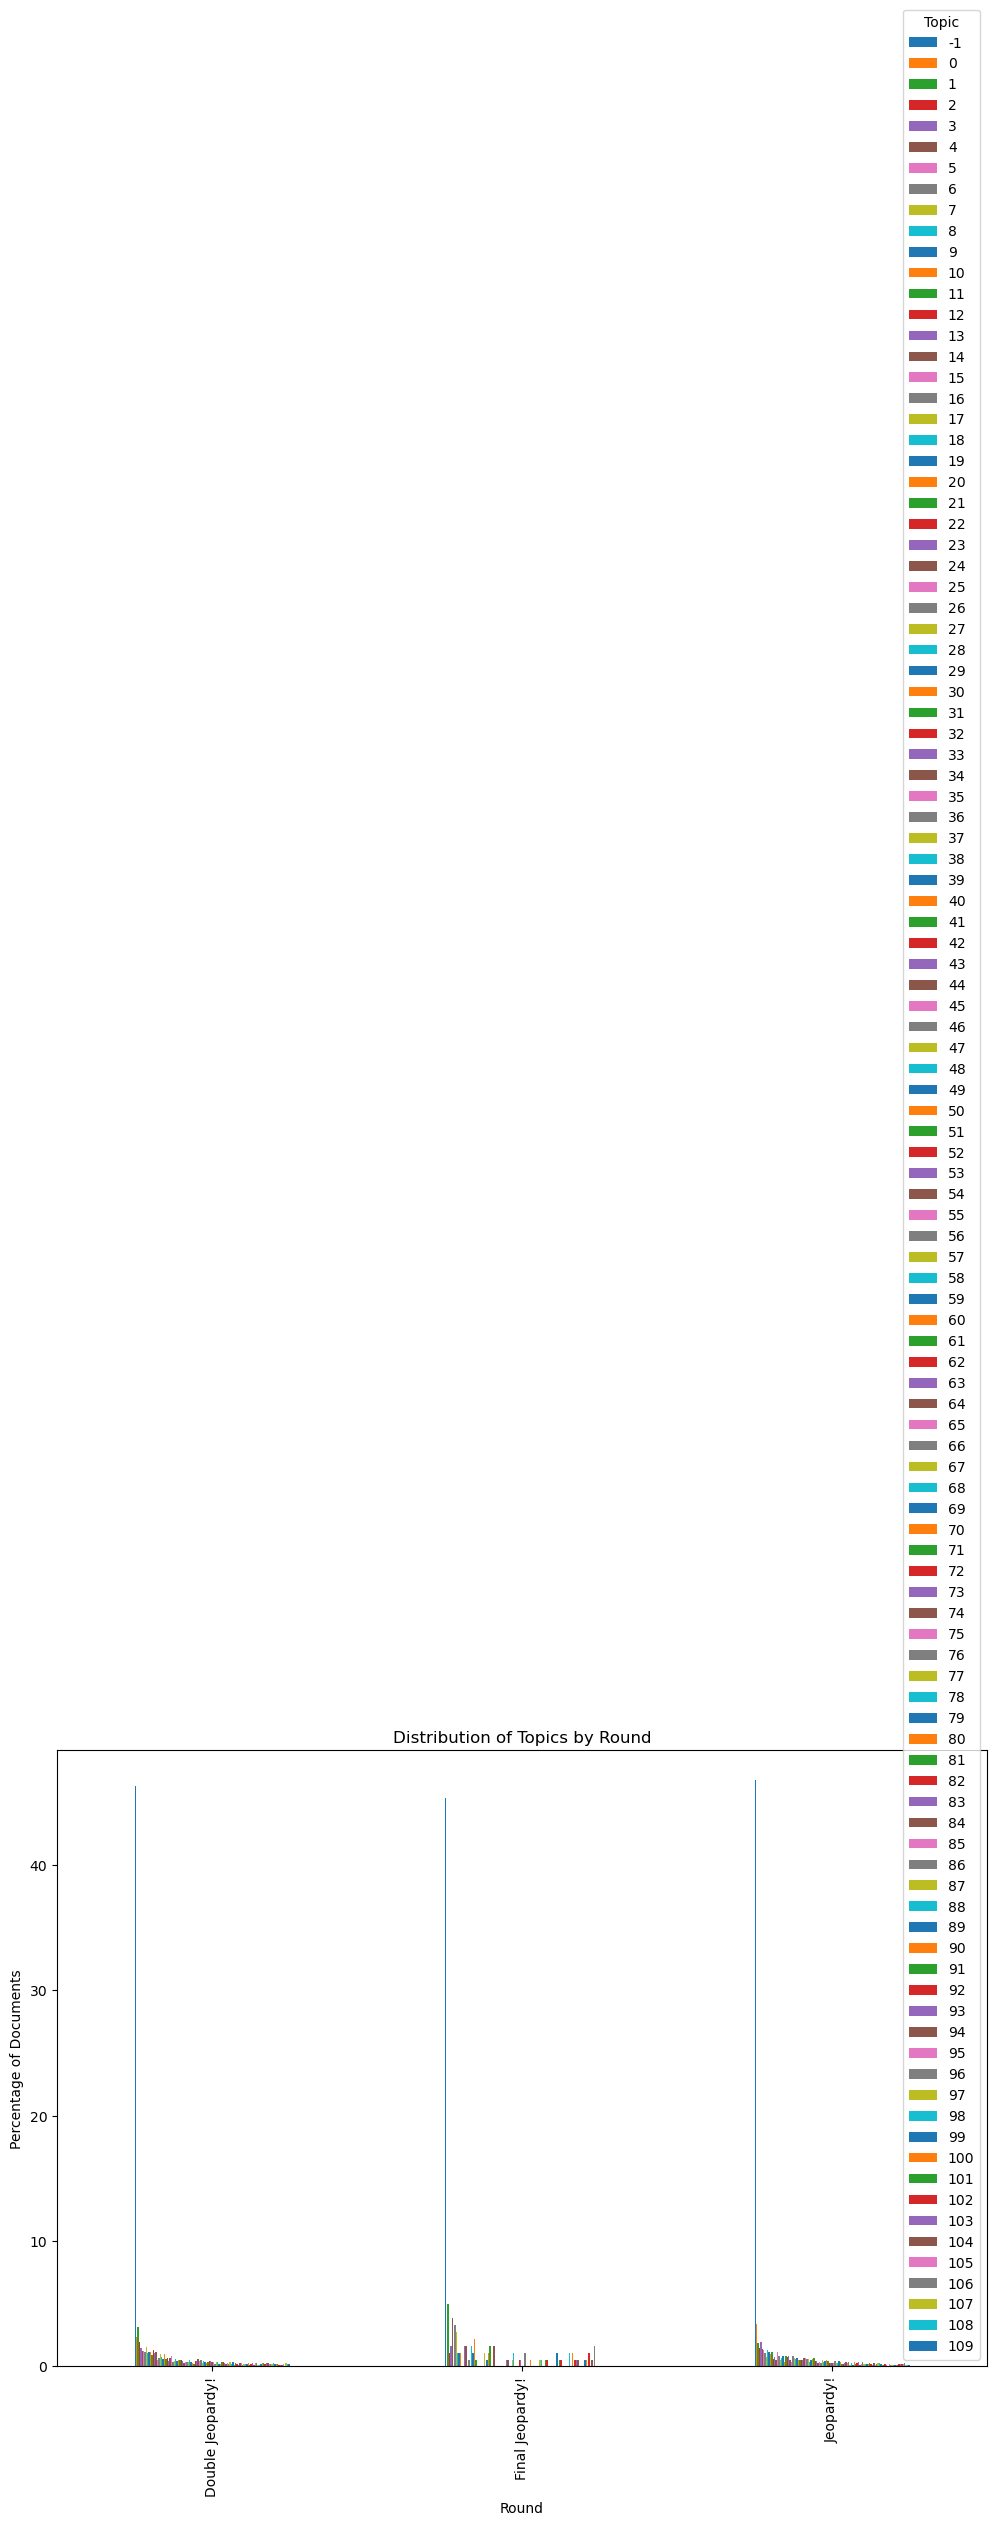

In [35]:
# Pick your class column (for Jeopardy, maybe 'Round' or 'Category')
class_col = "Round"  # or "Category"

# Add topics to your dataframe
df["Topic"] = topics

# Drop rows with missing class values (if any)
df_reduced = df.dropna(subset=[class_col]).reset_index(drop=True)

# Compute topic counts per class
topic_distribution = df_reduced.groupby([class_col, "Topic"]).size().unstack(fill_value=0)

# Convert counts to percentages within each class
topic_distribution_percent = topic_distribution.div(topic_distribution.sum(axis=1), axis=0) * 100

# Optional: filter out a "Missing" class if it exists
topic_distribution_percent_filtered = topic_distribution_percent.loc[
    topic_distribution_percent.index != "Missing"
]

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
topic_distribution_percent_filtered.plot(kind="bar", ax=ax)
ax.set_ylabel("Percentage of Documents")
ax.set_title(f"Distribution of Topics by {class_col}")
plt.tight_layout()

# Save and show
plt.savefig(f"topics_by_{class_col.lower()}.pdf", format="pdf", bbox_inches="tight")
plt.show()

Topic                  -1         0         1         2         3         4    \
Round                                                                           
Double Jeopardy!  46.316852  2.361251  3.128153  1.957619  1.453078  1.210898   
Final Jeopardy!   45.303867  0.000000  4.972376  1.104972  1.657459  3.867403   
Jeopardy!         46.772204  3.412829  1.870888  1.480263  1.912007  1.356908   

Topic                  5         6         7         8    ...       100  \
Round                                                     ...             
Double Jeopardy!  1.271443  1.190716  1.574168  1.049445  ...  0.221998   
Final Jeopardy!   0.000000  3.314917  2.762431  1.104972  ...  0.552486   
Jeopardy!         1.274671  1.110197  0.719572  1.295230  ...  0.123355   

Topic                  101       102       103       104       105       106  \
Round                                                                          
Double Jeopardy!  0.221998  0.141271  0.121090  0.141271  

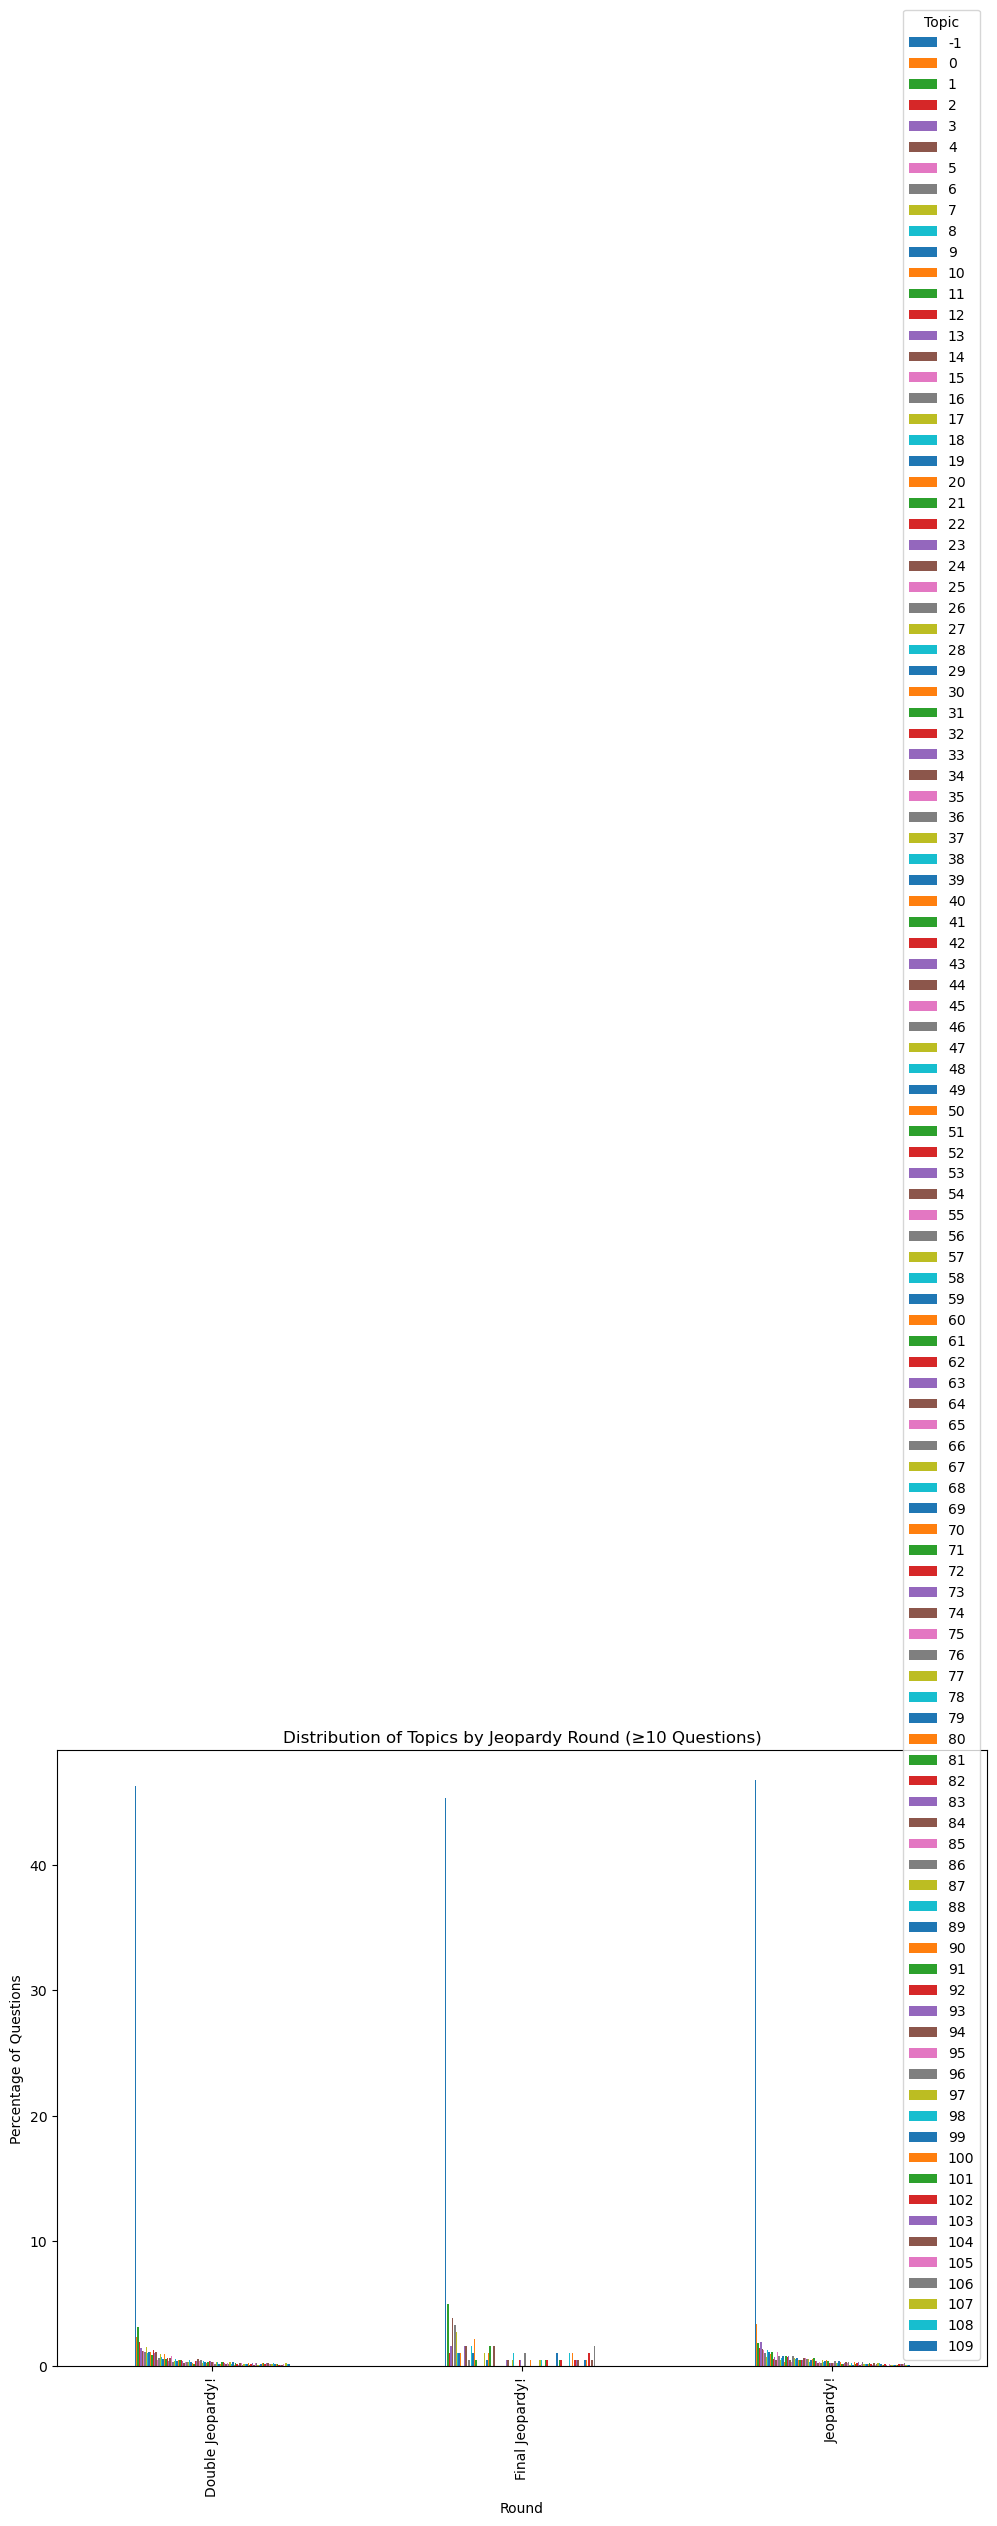

In [37]:
# Group by Round and Topic to get topic counts per round
topic_distribution_round = (
    df_reduced.groupby(["Round", "Topic"]).size().unstack(fill_value=0)
)

# Filter to only include rounds with at least 10 questions
min_docs = 10
topic_distribution_round = topic_distribution_round[
    topic_distribution_round.sum(axis=1) >= min_docs
]

# Convert to percentages within each round
topic_distribution_round_percent = (
    topic_distribution_round.div(topic_distribution_round.sum(axis=1), axis=0) * 100
)

# Preview results
print(topic_distribution_round_percent.head())

# Plot the topic distributions by round
fig, ax = plt.subplots(figsize=(12, 8))
topic_distribution_round_percent.plot(kind="bar", ax=ax)
ax.set_ylabel("Percentage of Questions")
ax.set_title("Distribution of Topics by Jeopardy Round (≥10 Questions)")
plt.tight_layout()

# Save to PDF
plt.savefig("topics_by_round_min10.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [72]:
topic_distribution_round_percent.to_csv('topics_by_round_at_least_10_questions.csv', index=True) 
topic_distribution_round.to_csv('topics_by_round_at_least_10_questions_counts.csv', index=True)

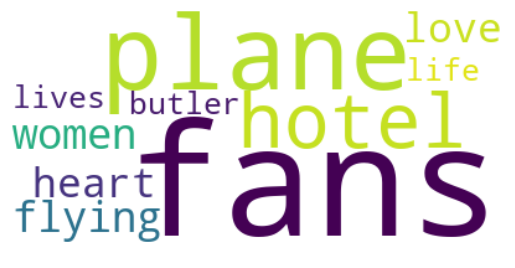

In [38]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=1)

In [39]:
import os
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordclouds_for_all_topics(model, save_directory, topic_distribution_percent, group_label="Round"):
    """
    Create and save word clouds for each topic discovered by BERTopic.
    The title of each word cloud includes topic ID and the percentage of questions
    from each Jeopardy round (or any other grouping variable).
    """

    # 1️⃣ Create output directory
    os.makedirs(save_directory, exist_ok=True)
    
    # 2️⃣ Get topic overview
    topics_info = model.get_topic_info()

    # 3️⃣ Loop through all topics (skip outlier topic -1 if present)
    for _, row in topics_info.iterrows():
        topic_number = row["Topic"]
        if topic_number == -1:   # Optional: skip outlier topic
            continue
        
        # Get the words and their importance scores
        words = model.get_topic(topic_number)
        if not words:
            continue
        
        # Convert to dict for WordCloud
        word_freqs = {word: value for word, value in words}
        
        # Retrieve the percentage of documents per group (e.g., Round) for this topic
        round_labels = topic_distribution_percent.index.tolist()
        percentages = []
        for label in round_labels:
            val = topic_distribution_percent.loc[label, topic_number] if topic_number in topic_distribution_percent.columns else 0
            percentages.append(f"{label}: {val:.2f}%")
        
        # Build the title (e.g., "Topic 3 — Jeopardy!: 45% | Double Jeopardy!: 55%")
        title_text = f"Topic {topic_number} — " + " | ".join(percentages)

        # Create the WordCloud
        wc = WordCloud(background_color="white", max_words=200, width=800, height=400)
        wc.generate_from_frequencies(word_freqs)

        # Plot
        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation="bilinear")
        plt.title(title_text, pad=20)
        plt.axis("off")
        plt.tight_layout()

        # Save to file
        file_path = os.path.join(save_directory, f"topic_{topic_number}.png")
        plt.savefig(file_path)
        plt.close()

In [43]:
# Assuming you already have topic_distribution_round_percent from previous step
create_wordclouds_for_all_topics(
    topic_model,
    save_directory="./topic_wordclouds_round",
    topic_distribution_percent=topic_distribution_round_percent,
    group_label="Round"
)

✅ Word clouds saved to: ./topic_wordclouds_round


In [40]:
# Filter the DataFrame to get documents where the topic is 16
topic_16_docs = df[df['Topic'] == 16]

# Display these documents
print(topic_16_docs) 

        Show Number   Air Date             Round  \
171830         4993 2006-05-03         Jeopardy!   
114033         3941 2001-10-22  Double Jeopardy!   
82033          5324 2007-11-01  Double Jeopardy!   
189604         5329 2007-11-08         Jeopardy!   
205038         4551 2004-05-24         Jeopardy!   
...             ...        ...               ...   
147133         5245 2007-06-01  Double Jeopardy!   
102319         3398 1999-05-19  Double Jeopardy!   
213605         4531 2004-04-26         Jeopardy!   
44288          4864 2005-11-03         Jeopardy!   
177678         3125 1998-03-13         Jeopardy!   

                                     Category   Value  \
171830                         1984 TV DEBUTS    $400   
114033                           ENDS IN "FF"    $400   
82033           THE HOUSE OF BURGESS MEREDITH   $1200   
189604                          TV DETECTIVES    $200   
205038                          GET YOUR PHIL    $200   
...                              

In [41]:
# Get the overview of all topics
topic_info = topic_model.get_topic_info()

# Get top words for each topic; assuming we take the top 5 words for simplicity
top_words_per_topic = {}
for index, row in topic_info.iterrows():
    topic_number = row['Topic']
    if topic_number != -1:  # Exclude the outlier topic if present
        top_words = topic_model.get_topic(topic_number)
        # Format top words as a single string
        top_words_str = ", ".join([word for word, _ in top_words[:5]])
        top_words_per_topic[topic_number] = top_words_str

# If the topic model includes an outlier topic (-1), you can manually handle it
if -1 in top_words_per_topic:
    top_words_per_topic[-1] = "Outlier/Other"

# Assuming 'Topic' is the column in df that contains the topic numbers
df['Top_Words'] = df['Topic'].map(top_words_per_topic)


df.head()


,Show Number,Air Date,Round,Category,Value,Question,Answer,Year,year,notes,Topic,Top_Words
167924,3460,1999-09-24,Double Jeopardy!,CANADIAN TOURISM,$600,Each year this British Columbia city hosts the...,Vancouver,1999,1999,Each year this British Columbia city hosts the...,-1,NaN
48860,4200,2002-11-29,Jeopardy!,I GET NO KICK FROM CAMPAIGN,$1000,The only Republican presidential nominee to lo...,Dewey,2002,2002,The only Republican presidential nominee to lo...,4,"position, officer, beat, secretary, men"
94899,4605,2004-09-17,Double Jeopardy!,BRING OUT YOUR DEAD,$800,"The alternate title to the Anne Rice book ""Ram...",a mummy,2004,2004,"The alternate title to the Anne Rice book ""Ram...",-1,NaN
4510,6288,2012-01-11,Jeopardy!,CATHOLIC PRIESTS,$600,The priest's duty to keep your sins secret is ...,the confessional,2012,2012,The priest's duty to keep your sins secret is ...,-1,NaN
158549,4083,2002-05-08,Double Jeopardy!,TOUGH GEOGRAPHY,$1600,This last colony in Africa shares part of its ...,Western Sahara,2002,2002,This last colony in Africa shares part of its ...,52,"italian, holiday, hat, 1835, john"


In [42]:
# Write the DataFrame to a CSV file
df.to_csv('notes_with_topics.csv', index=False)  # Set index=False if you do not want to write the row indices to the file

✅ saved: ./jeopardy_wordcloud_all_questions.png


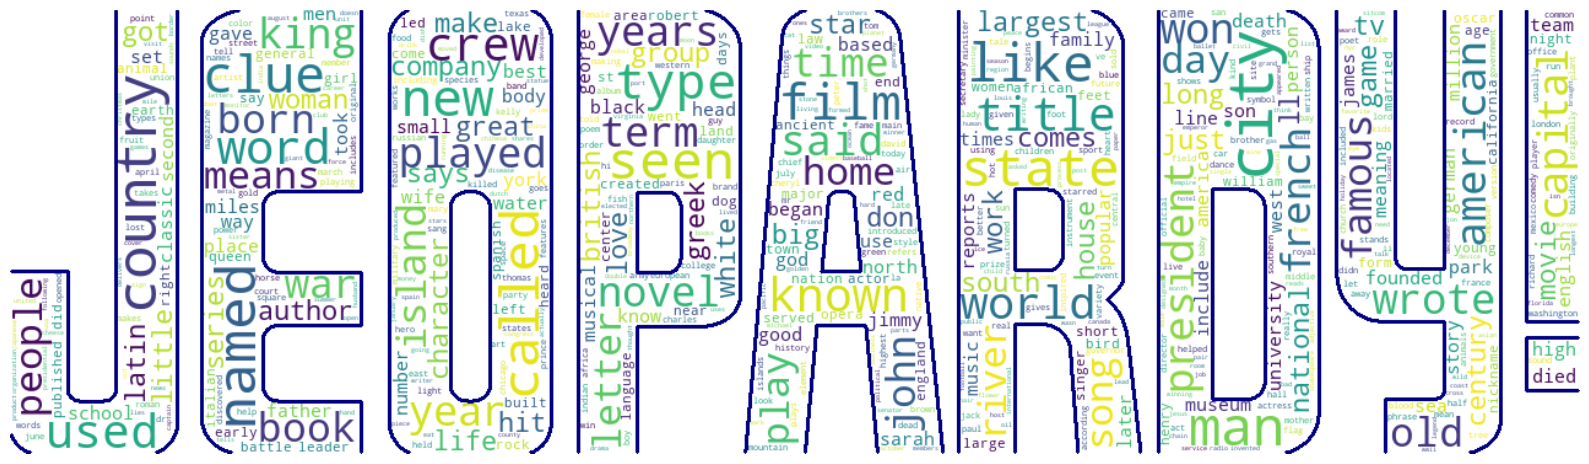

In [47]:
# create a fun shaped word cloud
import numpy as np
from PIL import Image, ImageOps
from wordcloud import WordCloud, STOPWORDS


# --- inputs you control ---
CSV_PATH = "JEOPARDY_CSV_cleaned.csv"
TEXT_COL = "Question"
MASK_PATH = "./jeopardy.png"
OUT_PATH = "./jeopardy_wordcloud_all_questions.png"

# 1) Load text
df = pd.read_csv(CSV_PATH)
texts = df[TEXT_COL].astype(str).tolist()

# 2) Get word frequencies (basic English stopwords)
cv = CountVectorizer(stop_words="english", token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z]+\b")
X = cv.fit_transform(texts)
freq = np.asarray(X.sum(axis=0)).ravel()
vocab = np.array(cv.get_feature_names_out())
freqs = dict(zip(vocab, freq))

# --- Load the logo mask ---
logo = Image.open(MASK_PATH).convert("RGBA")

# Extract the alpha (transparency) channel:
alpha = logo.getchannel("A")

# Invert it: transparent areas become white (255), logo area becomes black (0)
# WordCloud treats white (255) as “blocked” and black (0) as “fillable”
mask = ImageOps.invert(alpha)
mask = np.array(mask)

# 4) Build & save word cloud
wc = WordCloud(
    width=1600, height=800,
    background_color="white",   # or "black"
    stopwords=STOPWORDS,
    mask=mask,
    max_words=1000,
    contour_width=2, contour_color="navy",  # nice outline
)
wc.generate_from_frequencies(freqs)

plt.figure(figsize=(16,8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()
wc.to_file(OUT_PATH)
print(f"✅ saved: {OUT_PATH}")